<a href="https://colab.research.google.com/github/hafilmr/LearningCodeTrainee/blob/main/Exponential%20Smoothing/ETS_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

--2022-02-03 09:54:16--  https://lazyprogrammer.me/course_files/sp500sub.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25473876 (24M) [text/csv]
Saving to: ‘sp500sub.csv’

sp500sub.csv        100%[===================>]  24.29M  7.85MB/s    in 3.4s    

2022-02-03 09:54:21 (7.16 MB/s) - ‘sp500sub.csv’ saved [25473876/25473876]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [ ]:
!head sp500sub.csv

Date,Open,High,Low,Close,Adj Close,Volume,Name
2010-01-04,9.220000267028807,9.510000228881836,9.170000076293944,9.5,9.5,1865400.0,INCY
2010-01-05,9.510000228881836,10.289999961853027,9.449999809265137,10.270000457763672,10.270000457763672,7608900.0,INCY
2010-01-06,10.380000114440918,11.09000015258789,10.350000381469727,11.0,11.0,8046700.0,INCY
2010-01-07,11.0,11.0600004196167,10.619999885559082,10.81999969482422,10.81999969482422,3680300.0,INCY
2010-01-08,10.81999969482422,11.0,10.75,10.9399995803833,10.9399995803833,1529300.0,INCY
2010-01-11,10.960000038146973,11.239999771118164,10.880000114440918,11.09000015258789,11.09000015258789,2280600.0,INCY
2010-01-12,10.989999771118164,11.0,10.34000015258789,10.359999656677246,10.359999656677246,4204600.0,INCY
2010-01-13,10.359999656677246,10.460000038146973,10.039999961853027,10.329999923706056,10.329999923706056,2134900.0,INCY
2010-01-14,10.3100004196167,10.390000343322754,10.079999923706056,10.15999984741211,10.15999984741211,2889600.0,INCY

In [ ]:
!pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 11.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
df = pd.read_csv('/content/sp500sub.csv', index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [ ]:
goog = df[df['Name'] == 'GOOG'][['Close']].copy()
# get all data in df, but only contain "GOOG"
goog

,Close
Date,
2010-01-04,312.204773
2010-01-05,310.829926
2010-01-06,302.994293
2010-01-07,295.940735
2010-01-08,299.885956
...,...
2018-12-21,979.539978
2018-12-24,976.219971
2018-12-26,1039.459961


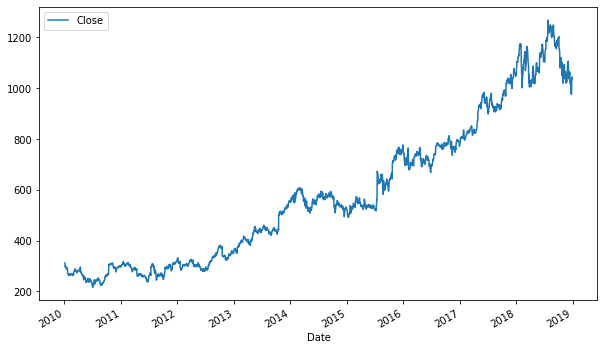

In [ ]:
goog.plot(figsize=(10, 6))

#### **Log Transform**

Make new column to fill in the values of log transform

In [ ]:
goog['LogClose'] = np.log(goog['Close'])

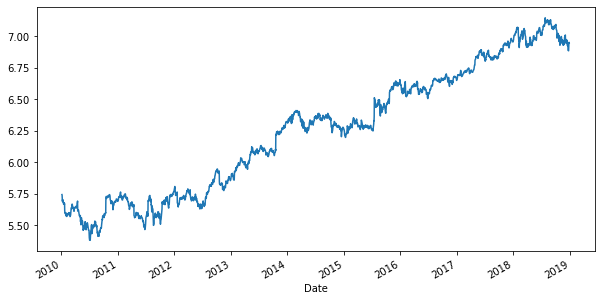

In [ ]:
goog['LogClose'].plot(figsize=(10, 5))

Next step is to split our data into training tests I've chosen and testicles 30, which might be a bit long.

So feel free to change this to whatever you like.

In [ ]:
Ntest = 30
train = goog.iloc[:-Ntest]
test = goog.iloc[-Ntest:]

In [ ]:
# boolean series to index df rows
train_idx = goog.index <= train.index[-1]
test_idx = goog.index > train.index[-1]

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Next step is to instantiate our model, since I don't believe this data has any seasonality.

I've said Seasonale to none again.
Feel free to test different parameters and see what works best.

In [ ]:
hw = ExponentialSmoothing(
    train['LogClose'],
    initialization_method = 'legacy-heuristic',
    trend = 'add', seasonal=None
)

res_hw = hw.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Note that we technically didn't have to take the log ourselves, since that's models can do this internally, Also observe that we get a warning since our data frame index doesn't have a frequency.


In [ ]:
goog.loc[train_idx, 'HoltWintersTrain'] = res_hw.fittedvalues

In [ ]:
goog.loc[test_idx, 'HoltWintersTest'] = res_hw.forecast(Ntest).to_numpy()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


For the test set, you see that I've converted the result into an numpy array.

This is because not having a frequency for the index messes up the forecast indices and this will mess up where it goes in the data frame.

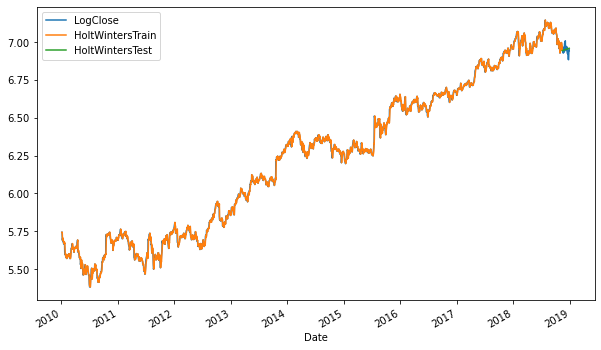

In [ ]:
goog[['LogClose', 'HoltWintersTrain', 'HoltWintersTest']].plot(figsize=(10, 6))

Notice how nice they look for the train set, but don't be fooled. Of course, what really matters is the test set.


So in order to get a better picture of what's going on, we're going to plot only the last one hundred data points.


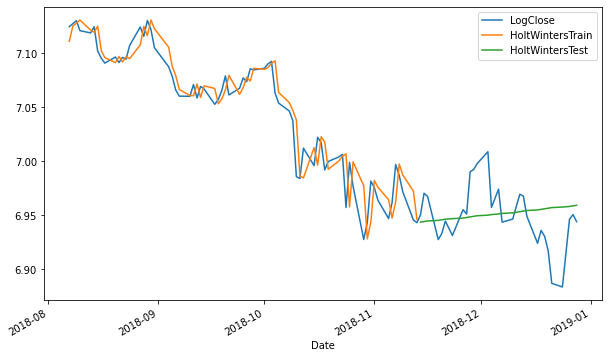

In [ ]:
cols = ['LogClose', 'HoltWintersTrain', 'HoltWintersTest']
goog.iloc[-100:][cols].plot(figsize=(10, 6))


So the result is not too surprising.
We see that our model only appears to do well on the train set because it copies the last value.

This makes sense since the log price nearly follows a random walk.

And of course, the forecast is a straight line since we've used holds linear trend model to fit our



As an exercise.

Try to compute one of our forecasting metrics for this prediction and compare it to the night forecast.

Remember that for the naive forecast, we have to propagate the last known value through the forecast horizon.

So don't copy the last value within the test set, but only copy the last value from the train set.

This should give you a horizontal line.

So in other words, see if a horizontal line is better than Holt'S Linear trend line.


In [ ]:
goog.loc[test_idx, 'Naive'] = train.iloc[-1]['LogClose']

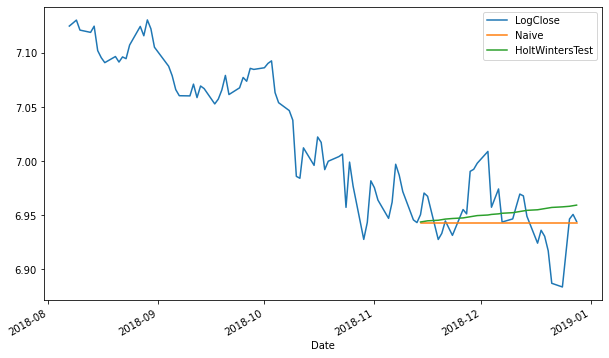

In [ ]:
goog.iloc[-100:][['LogClose', 'Naive', 'HoltWintersTest']].plot(figsize=(10, 6))

In [ ]:
r2_score(goog.loc[test_idx, 'LogClose'], goog.loc[test_idx, 'Naive'])

-0.06454209862026317

In [ ]:
r2_score(goog.loc[test_idx, 'LogClose'], goog.loc[test_idx, 'HoltWintersTest'])

-0.1587652478748407